In [1]:
# Needed to import modules from helpers
import sys
import os
import time
import requests
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import esm
from io import StringIO
from Bio import SeqIO

current_dir = os.getcwd()
# Gehe einen Ordner nach oben
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from helpers import helper

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load ESM model to GPU

In [2]:
# kleineres Modell 'esm2_t6_8M_UR50D' zum testen 
# verwendet 36-layer Transformer trained on UniParc" (ca. 670 Mio. Parameter ) im Paper.
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")

# Get Data

before: 
"""
    "KOG0069",  #Enolase (Housekeeping, meist Single-Copy -> saubere Punkte)
    "KOG0100", # HSP90 (Referenz aus dem Paper Fig. 7, strukturell interessant)
    "KOG3889", #, Hämoglobin Beta (Zeigt gut die Evolution Vögel vs. Säuger)
    "KOG2064" # Calmodulin (Referenz aus Paper Fig. 7, sehr konserviert)
"""

In [4]:
# These are Eukaryotic Orthologous Groups (KOGs) for key proteins.
orthologous_groups = [
    "KOG1695",
    "KOG0036",
    "KOG1721",
    "KOG3187"
]

data = []

for group in orthologous_groups:
    url = f"http://eggnogapi5.embl.de/nog_data/json/fasta/{group}"

    # print(url)

    # When adding a try except block we ensure that the program continues even if a request fails
    try:
        response = requests.get(url)

        fasta_content = response.json().get('fasta', '')

        for item in fasta_content.split('>')[1:]:

            # print(f"specimen: {item.split('.')[0]}")
            # print(f"gene: {item.splitlines()[0].split('.')[1]}")
            # print(f"sequence: {item.splitlines()[1]}")

            data.append({
                "group_id": group,
                "specimen": item.split('.')[0],
                "gene": item.splitlines()[0].split('.')[1],
                "sequence": item.splitlines()[1]
            })
        
    except Exception as e:
        print(f"Error {group}: {e}")

    time.sleep(0.1)  # Be polite and avoid overwhelming the server



In [5]:
data_df= pd.DataFrame(data)
print(data_df.info())
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82020 entries, 0 to 82019
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   group_id  82020 non-null  object
 1   specimen  82020 non-null  object
 2   gene      82020 non-null  object
 3   sequence  82020 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB
None


,group_id,specimen,gene,sequence
0,KOG1695,2850,Phatr34976,MVRVIVVTKCEDVPTKPVDDKPMLVYWNLLGLVQFNRFALIQADVD...
1,KOG1695,2850,Phatr37658,MTPLPKIKLTYFDIEGVAEAVRLALVLSNTPFEDDRVGFGDWGEMK...
2,KOG1695,2903,EOD03691,MRSGLRRLAVPAALTAAATTALGAGRLVASQSGHVAAASAEADASP...
3,KOG1695,2903,EOD09578,MPKRTHDEAQPKLKLYYFDIQGKAEAIRLLCKYVGLELDDYRFKDR...
4,KOG1695,2903,EOD10194,MSMSLLLLALASSSLTLKYFDARGAAEVTRVLLAVGGLEFKDHRYA...


In [6]:
# Chicken (Gallus gallus)
# TaxID: 9031
mask_chicken = data_df['specimen'] == "9031"
data_df[mask_chicken]

# Human (Homo sapiens)
# TaxID: 9606 
mask_human = data_df['specimen'] == "9606"
data_df[mask_human]

# Chimpanzee (Pan troglodytes)
# TaxID: 9598
mask_chimpanzee = data_df['specimen'] == "9598"
data_df[mask_chimpanzee]

# zebra fish 
mask_zebrafish = data_df['specimen'] == "7955"
data_df[mask_zebrafish]

# Mouse (Mus musculus)
# TaxID: 10090
mask_mouse = data_df['specimen'] == "10090"
data_df[mask_mouse]

,group_id,specimen,gene,sequence
1014,KOG1695,10090,ENSMUSP00000004134,MSSKSMVLGYWDIRGLAHAIRMLLEFTDTSYEEKRYICGEAPDYDR...
1015,KOG1695,10090,ENSMUSP00000004136,MPMTLGYWNTRGLTHSIRLLLEYTDSSYEEKRYVMGDAPNFDRSQW...
1016,KOG1695,10090,ENSMUSP00000004137,MPMTLGYWDIRGLAHAIRLFLEYTDSSYEEKRYTMGDAPDYDQSQW...
1017,KOG1695,10090,ENSMUSP00000004140,MPMILGYWNVRGLTHPIRMLLEYTDSSYDEKRYTMGDAPDFDRSQW...
1018,KOG1695,10090,ENSMUSP00000012348,MPMTLGYWDIRGLAHAIRLLLEYTDTSYEDKKYTMGDAPDYDRSQW...
...,...,...,...,...
45732,KOG1721,10090,ENSMUSP00000141137,MASCQVPLTFMDVALEFSKEEWECLDSAQKALYRDVMLENYNSLVS...
81479,KOG3187,10090,ENSMUSP00000044955,METQVLTPHVYWAQRHRELYLRVELSDVQNPAISITDNVLHFKAQG...
81480,KOG3187,10090,ENSMUSP00000060462,MAAAAATAATKGNGGGSGRVGAGDSSGARKKKGPGPVATAYLVIYN...
81481,KOG3187,10090,ENSMUSP00000110401,MASSEEDGTNGASEASDEKEAAGKRRRLGLLATAWLTFYNIAMTAG...


In [ ]:
# Needed to make run as test
data_df = data_df.sample(200)

In [7]:
# Get the labels for genes and species and the according sequences
labels = list(data_df["group_id"])
seqs = list(data_df["sequence"])

### Hypothesis 1:

The model learns to group proteins based on their evolutionary origin/relationship (homology). Proteins belonging to the same sequence family (orthologs = genes with same ancestor, which have diverged in their sequence a bit) are expected to lie close to one another in the embedding space, even if their sequences have diverged due to mutations.

While the organization of proteins in the representation space is diffuse prior to training, we expect clear clusters to emerge after training, reflecting evolutionary relationships.

### Method:

Each protein (sequence x) is processed by the Transformer model. We extract the final hidden representation for sequence token. To obtain a single vector representation for the entire protein, we average these values across the sequence length (mean pooling).​	
 
This process projects each Sequence/Protein as a single point in a high-dimensional space. To visualize this high-dimensional structure, we use t-SNE (t-Distributed Stochastic Neighbor Embedding) to project the embeddings onto two dimensions for analysis

### Unigram Embeddings

In [8]:
# This baseline maps each sequence to a vector of normalized amino acid counts 
def get_unigram_embeddings(sequences):
    alphabet = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    
    # Create matrix: (Num_Sequences x 20)
    embeddings = np.zeros((len(sequences), 20))
    
    for i, seq in enumerate(sequences):
        if len(seq) == 0: continue
        
        # Count residues
        for char in seq.upper():
            if char in aa_to_idx:
                idx = aa_to_idx[char]
                embeddings[i, idx] += 1
                
        # Normalize by length to get frequencies
        embeddings[i] = embeddings[i] / len(seq)
        
    return embeddings

# Calculate Unigram Embeddings
emb_unigram = get_unigram_embeddings(seqs)

### Untrained Transformer Embeddings

In [22]:
# 2. Get embeddings before pretraining (natürlich ist hier ein Problem, dass wir den seed nicht kennen alleine deshalb werden sich hier Sachen vom original Paper unterscheiden)
print("Calculating UNTRAINED Embeddings...")
untrained_model = helper.randomize_model(model)

if torch.cuda.is_available(): 
    untrained_model = untrained_model.cuda()

# Schritt 1: Calculate final hidden representations
token_reps_untrained, batch_strs_untrained = helper.get_hidden_representations(untrained_model, alphabet, labels, seqs)

# Schritt 2: Calculate Untrained Embeddings
emb_untrained = helper.get_protein_embedding(token_reps_untrained, batch_strs_untrained)

Calculating UNTRAINED Embeddings...
Processing 200 sequences in batches of 1...


### Trained Transformer Embeddings

In [23]:
# 1. Get embeddings after pretraining
print("Calculating TRAINED Embeddings...")

# Schritt 1: Calculate final hidden representations
token_reps_trained, batch_strs_trained = helper.get_hidden_representations(model, alphabet, labels, seqs)

# Schritt 2: Calculate Trained Embeddings
emb_trained = helper.get_protein_embedding(token_reps_trained, batch_strs_trained)

Calculating TRAINED Embeddings...
Processing 200 sequences in batches of 1...


### TSNE Dimensionality reduction

In [24]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d_untrained = tsne.fit_transform(emb_untrained)

tsne_trained = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d_trained = tsne_trained.fit_transform(emb_trained)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d_unigram = tsne.fit_transform(emb_unigram)

### TSNE Visualization

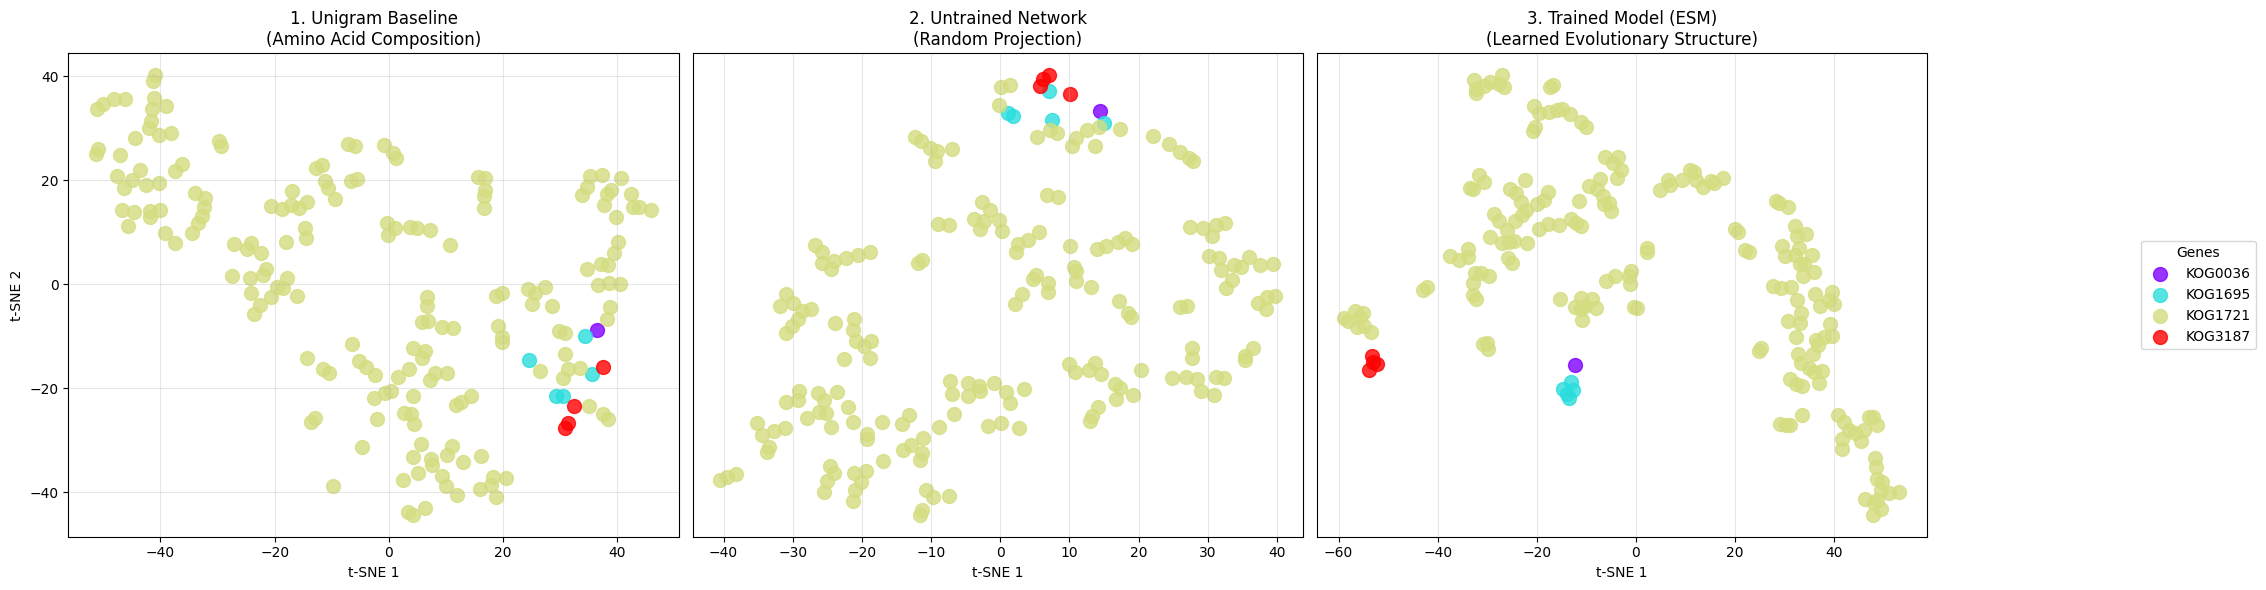

In [25]:
# 1. Setup Colors
# Extract unique gene names for coloring
unique_genes = sorted(list(set(labels)))
colors = cm.rainbow(np.linspace(0, 1, len(unique_genes)))
gene_color_map = dict(zip(unique_genes, colors))

# 2. Setup Figure (Now 1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# 3. Plotting Loop (Iterate by Gene to keep colors/legend clean)
for gene in unique_genes:
    # Find all indices for this specific gene
    # (Assuming labels list is available as defined in previous steps)
    indices = [i for i, label in enumerate(labels) if label.startswith(gene)]
    
    color = gene_color_map[gene]
    
    if indices:
        # --- Panel 1: Unigram Baseline (Input from your snippet) ---
        ax1.scatter(emb_2d_unigram[indices, 0], emb_2d_unigram[indices, 1], 
                    color=color, s=100, alpha=0.8, label=gene)
        
        # --- Panel 2: Untrained Model ---
        ax2.scatter(emb_2d_untrained[indices, 0], emb_2d_untrained[indices, 1], 
                    color=color, s=100, alpha=0.8) # No label here to avoid duplicate legend
        
        # --- Panel 3: Trained Model ---
        ax3.scatter(emb_2d_trained[indices, 0], emb_2d_trained[indices, 1], 
                    color=color, s=100, alpha=0.8)

# 4. Styling and Titles

# Ax1: Unigram
ax1.set_title("1. Unigram Baseline\n(Amino Acid Composition)")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, alpha=0.3)

# Ax2: Untrained
ax2.set_title("2. Untrained Network\n(Random Projection)")
ax2.set_xlabel("t-SNE 1")
ax2.set_yticks([]) # Optional: Hide ticks for cleaner look
ax2.grid(True, alpha=0.3)

# Ax3: Trained
ax3.set_title("3. Trained Model (ESM)\n(Learned Evolutionary Structure)")
ax3.set_xlabel("t-SNE 1")
ax3.set_yticks([]) 
ax3.grid(True, alpha=0.3)

# 5. Legend
# We only need one legend since the colors are consistent
# Placing it outside the last plot
handles, plot_labels = ax1.get_legend_handles_labels()
fig.legend(handles, plot_labels, loc='center right', title="Genes", bbox_to_anchor=(1.08, 0.5))

plt.tight_layout()
# Adjust right margin to make room for the external legend
plt.subplots_adjust(right=0.92) 
plt.show()

### Hypothesis 2: 

unsupervised learning encodes biological variations into the structure of the representation space. Das Modell lernt also ohne explizite Labels, fundamentale biologische Unterscheidungen zwischen species und gen familie. Die Autoren wenden eine Hauptkomponentenanalyse (PCA) auf die gelernten Repräsentationen von vier orthologen Genen über vier verschiedene Spezies hinweg an:

### Gene:
- "KOG1695" Glutamyl-tRNA synthetase
- "KOG1528" Phenylalanyl-tRNA synthetase
- "KOG1721" Alanyl-tRNA synthetase
- "KOG3187" Arginyl-tRNA synthetase


### Spezies:
- Chicken (Gallus gallus), TaxID: 9031
- Human (Homo sapiens), TaxID: 9606 
- Chimpanzee (Pan troglodytes), TaxID: 9598
- Mouse (Mus musculus), TaxID: 10090

### Beobachtung: 
Die PCA enthüllt, dass das trainierte Modell automatisch Achsen bildet, die biologisch interpretierbar sind:
- Eine Spezies-Achse (horizontal), die Organismen unterscheidet.
- Eine Orthologie-Achse (vertikal), die Gene unterscheidet.

Vergleich: Diese Struktur fehlt in untrainierten Modellen oder simplen Unigram-Modellen komplett. 

### Filter Data

In [9]:
target_ortholog_group = ["KOG1695", "KOG0036", "KOG1721", "KOG3187"]
target_species = ["9031", "9606", "9598", "10090", "7955"]

group_mask = data_df['group_id'].isin(target_ortholog_group)
species_mask = data_df['specimen'].isin(target_species)

data_unsorted = data_df[group_mask & species_mask]

data_unsorted['length'] = data_unsorted['sequence'].apply(len)

/tmp/ipykernel_4000235/3069219479.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_unsorted['length'] = data_unsorted['sequence'].apply(len)


In [10]:
df_sorted = data_unsorted.sort_values('length', ascending=False)

In [11]:
# Somehow we need to only take one but i dont get why there are duplicates here we should get 16 points
filtered_4by4_data = df_sorted.drop_duplicates(subset=['group_id', 'specimen'], keep='first')
filtered_4by4_data

,group_id,specimen,gene,sequence,length
32629,KOG1721,9598,ENSPTRP00000060230,MPGERPRGAPPPTMTGDLQPRQVASSPGHPSQPPLEDNTPATRTTK...,3928
33806,KOG1721,9606,ENSP00000402343,MPGERPRGAPPPTMTGDLQPRQVASSPGHPSQPPLEDNTPATRTTK...,3925
23895,KOG1721,9031,ENSGALP00000040998,GIKGSPQSPPGKGRTRERSRRAGKGERGQHQLYRLSIASTRPSPTI...,3801
17023,KOG1721,7955,ENSDARP00000106389,MDTKMWRTTLMTTTFILIAQLITTADASSPTDVTEGITPESYISFT...,3161
45147,KOG1721,10090,ENSMUSP00000037233,MADDEAEQERLSGGGCAAELRRLGERLQELERRLCESREPAVEAAA...,2698
2329,KOG0036,7955,ENSDARP00000088935,MHKRSSIVSPLLSGVFCQCRPEEYQGSDPGGGRTQGSTLAAVSVSE...,524
2578,KOG0036,10090,ENSMUSP00000028160,MVSSVLCRCVASPPPDAAATASSSASSPASVGDPCGGAVCGGPDHQ...,514
2401,KOG0036,9031,ENSGALP00000008158,ARRSLASPVVSGVLCPCGSPRAAAAPGTGAEGSGGGPCGRAVCEAS...,505
2480,KOG0036,9606,ENSP00000362159,MVSSVLCRCVASPPPDAAATAASSSASSPASVGDPCGGAICGGPDH...,503
2473,KOG0036,9598,ENSPTRP00000048889,MVSSVLCRCVASPPPDAAATAASSSASSPASVGDPCGGAICGGPDH...,503


### Compute PCA

In [12]:
# 1. Prepare Data
seqs = filtered_4by4_data['sequence'].tolist()
groups = filtered_4by4_data['group_id'].tolist()
specimens = filtered_4by4_data['specimen'].tolist()

# 2. Unigram Baseline
emb_unigram = get_unigram_embeddings(seqs)

# 3. Untrained Model Baseline
print("Calculating Untrained Embeddings...")
untrained_model = helper.randomize_model(model) 
if torch.cuda.is_available():
    untrained_model = untrained_model.cuda()

token_reps_untrained, batch_strs_untrained = helper.get_hidden_representations(
    untrained_model, alphabet, groups, seqs
)
emb_untrained = helper.get_protein_embedding(token_reps_untrained, batch_strs_untrained)

# 4. Trained Model (Real ESM)
print("Calculating Trained Embeddings...")
# Ensure we use the main, non-randomized model
token_reps_trained, batch_strs_trained = helper.get_hidden_representations(
    model, alphabet, groups, seqs
)
emb_trained = helper.get_protein_embedding(token_reps_trained, batch_strs_trained)

Calculating Untrained Embeddings...
Processing 20 sequences in batches of 1...


: 

### Visualize PCA

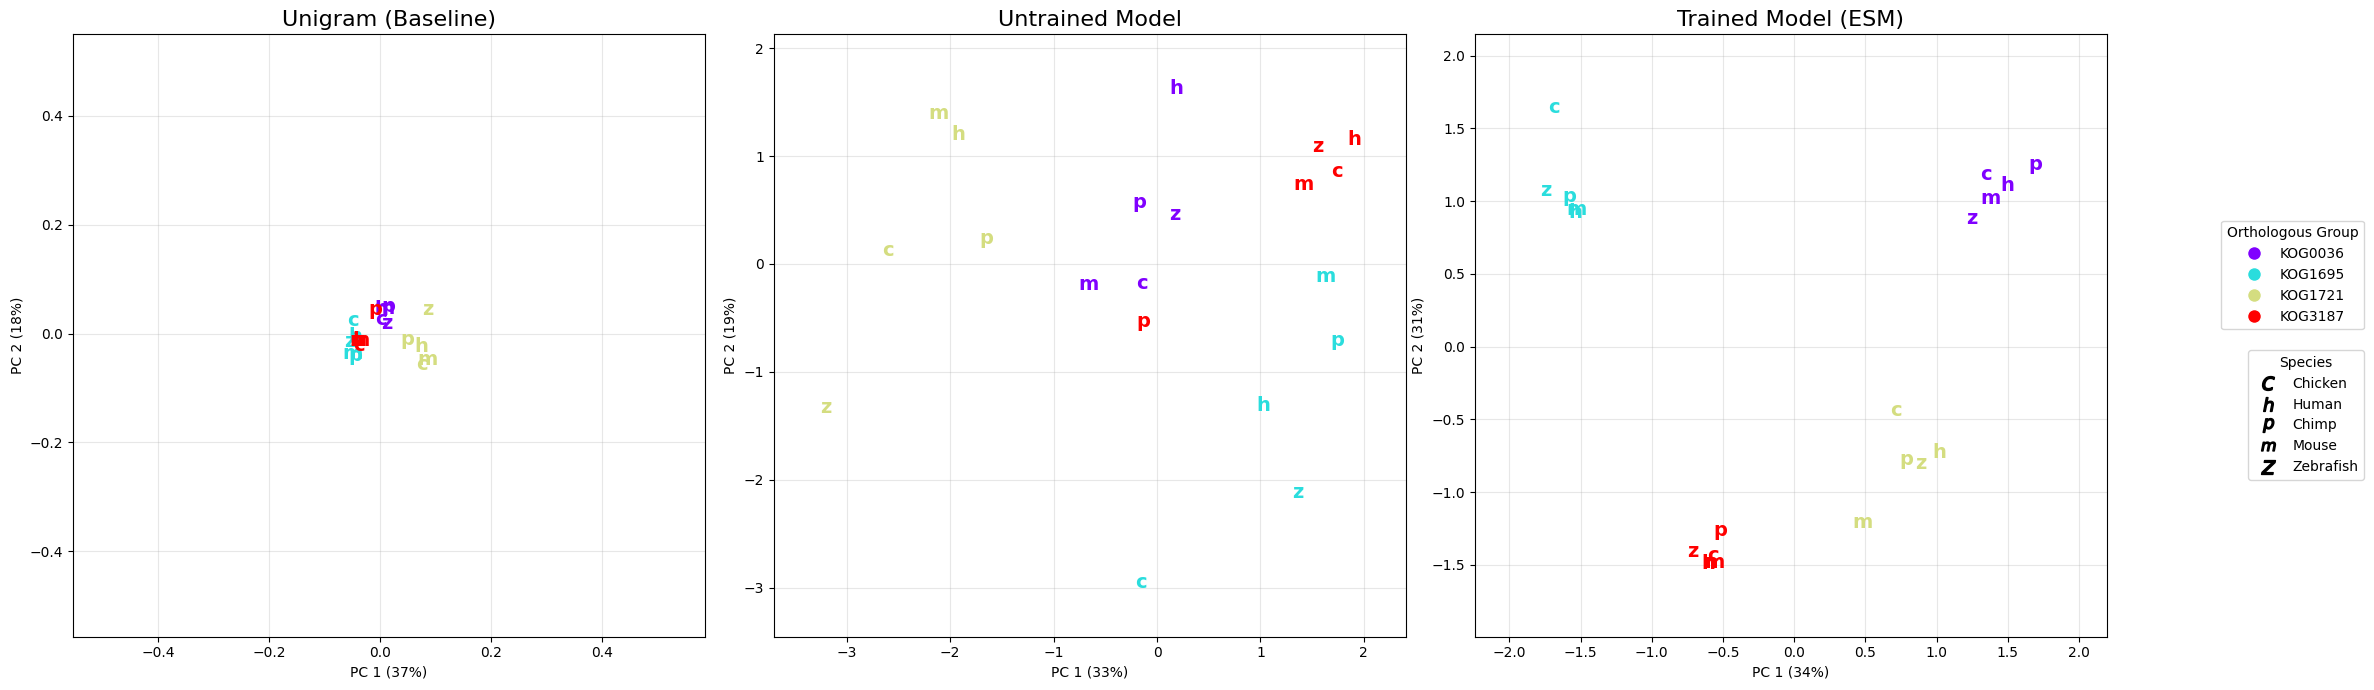

In [ ]:
# %%
# Visualisation
# 1. Setup Mappings for Tags and Full Names
species_map = {
    "9031": "c", "9606": "h", "9598": "p", "10090": "m", "7955": "z"
}
species_names = {
    "9031": "Chicken", "9606": "Human", "9598": "Chimp", "10090": "Mouse", "7955": "Zebrafish"
}

titles = ["Unigram (Baseline)", "Untrained Model", "Trained Model (ESM)"]
datasets = [emb_unigram, emb_untrained, emb_trained]

# Setup Colors
unique_groups = sorted(list(set(groups)))
colors = cm.rainbow(np.linspace(0, 1, len(unique_groups)))
group_color_map = dict(zip(unique_groups, colors))

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for i, ax in enumerate(axes):
    # Run PCA on the fly
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(datasets[i])
    
    # Plot Points
    for x, y, group, spec in zip(X_pca[:, 0], X_pca[:, 1], groups, specimens):
        color = group_color_map[group]
        tag = species_map.get(spec, "?")
        ax.text(x, y, tag, color=color, fontsize=14, fontweight='bold', ha='center', va='center')
    
    # Styling
    ax.set_title(titles[i], fontsize=16)
    ax.set_xlabel(f"PC 1 ({pca.explained_variance_ratio_[0]:.0%})")
    ax.set_ylabel(f"PC 2 ({pca.explained_variance_ratio_[1]:.0%})")
    ax.grid(True, alpha=0.3)
    
    # Zoom to fit
    ax.set_xlim(X_pca[:, 0].min() - 0.5, X_pca[:, 0].max() + 0.5)
    ax.set_ylim(X_pca[:, 1].min() - 0.5, X_pca[:, 1].max() + 0.5)

# --- LEGENDS ---

# 1. Orthologous Group Legend (Colors)
legend_lines = [Line2D([0], [0], marker='o', color='w', label=g, markerfacecolor=c, markersize=10) 
                for g, c in group_color_map.items()]
# Add first legend
l1 = fig.legend(handles=legend_lines, title="Orthologous Group", 
                loc='center right', bbox_to_anchor=(0.99, 0.6))

# 2. Species Legend (Letter Tags)
present_species = set(specimens)
legend_species = []
for taxid, tag in species_map.items():
    if taxid in present_species:
        name = species_names.get(taxid, taxid)
        # Use MathText to make the letter the marker
        h = Line2D([0], [0], marker=f"${tag}$", color='w', label=name, 
                   markerfacecolor='black', markeredgecolor='black', markersize=10)
        legend_species.append(h)

# Add second legend
fig.legend(handles=legend_species, title="Species", 
           loc='center right', bbox_to_anchor=(0.99, 0.4))

plt.tight_layout()
plt.subplots_adjust(right=0.88) # Make extra room for the legends
plt.show()

Hypothesis 3: biological properties are encoded along independent directions in the representation space

Then if we have two related sequences which only distiguish themselves by one unique property, they should only be differing along one of these separate axes

Vector(Human Insulin)−Vector(Human)+Vector(Mouse)≈Vector(Mouse Insulin)